In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split, StratifiedShuffleSplit
from sklearn import metrics
import xgboost as xgb

### Импорт данных

In [2]:
train_df = pd.read_excel('/content/drive/MyDrive/sasha_test/2_model_binary.xlsx', sheet_name='Train', )
test_df = pd.read_excel('/content/drive/MyDrive/sasha_test/2_model_binary.xlsx', sheet_name='Test')

### Анализ категориальных переменных

In [3]:
def positive_proportion(train, column_name):
    """
    Function for calculating and vizualization doles 
    of positive samples for each category of discrete variables.

    """
    num = len(np.unique(np.array(train[column_name])))
    positive_samples = []
    
    for value in np.unique(np.array(train[column_name])):
        positive_samples.append(len(train[(train[column_name]==value) & (train['y']=='yes')]))
    
    all_samples = []
    for value in np.unique(np.array(train[column_name])):
        all_samples.append(len(train[(train[column_name]==value)]))

    positive_samples = np.array(positive_samples)
    all_samples = np.array(all_samples)
    props = positive_samples/all_samples
    
    plt.figure(figsize=(15,6))
    plt.title(column_name)
    plt.bar(np.arange(num), props, label = 'Yes', alpha=0.9, color='red')
    plt.bar(np.arange(num), [1]*num, label='No', alpha=0.3, color='blue')
    plt.legend()
    plt.xticks(np.arange(num), (np.unique(np.array(train[column_name]))))

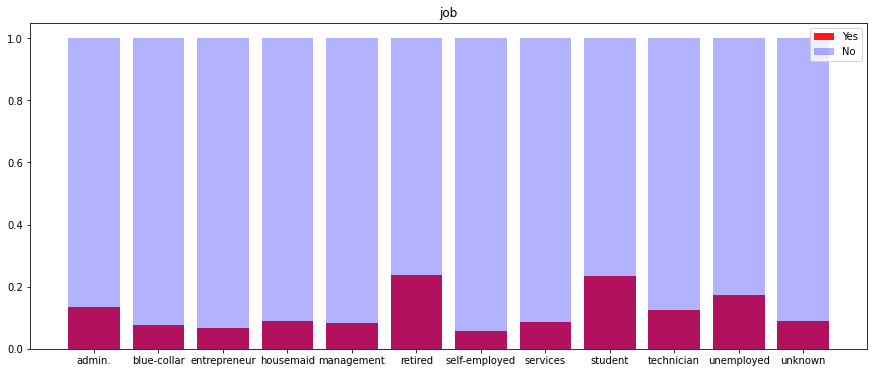

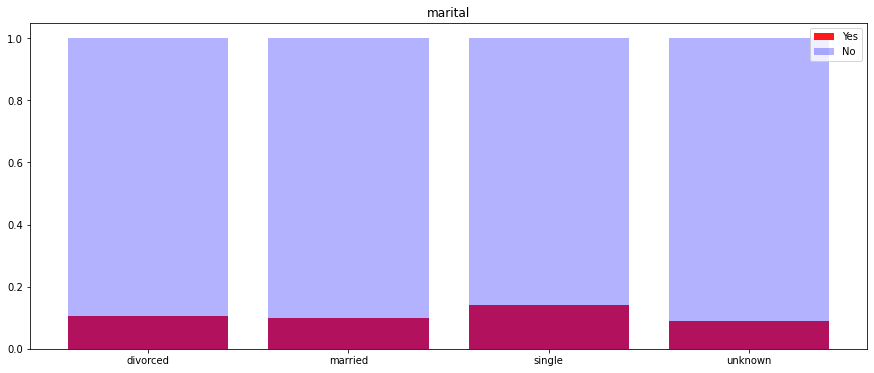

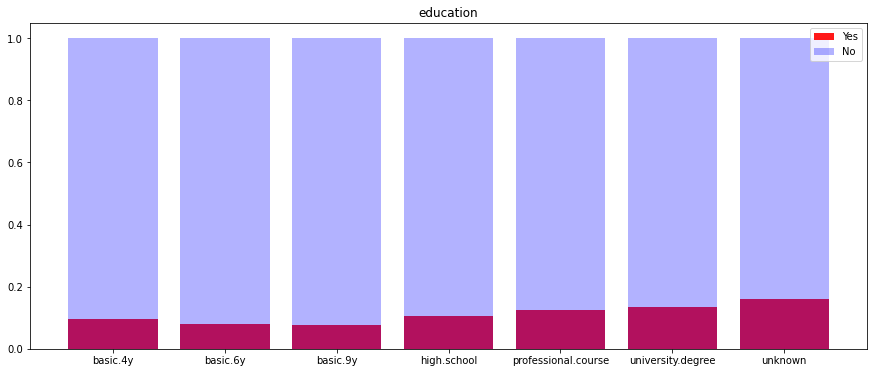

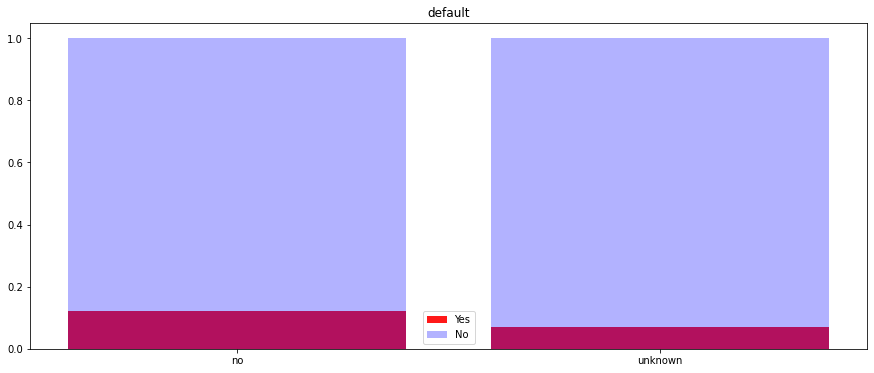

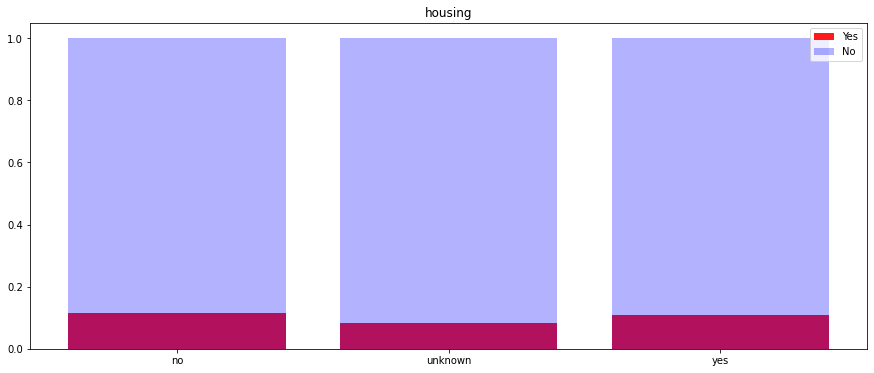

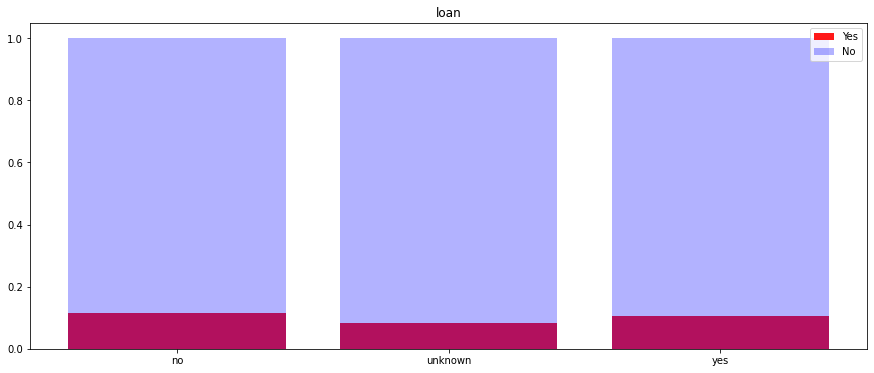

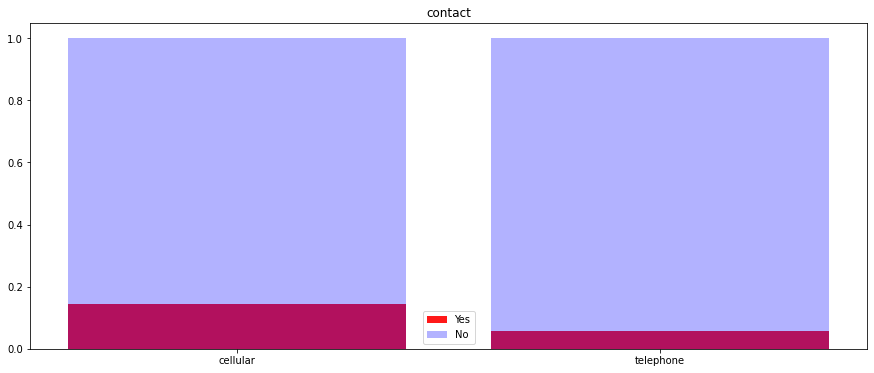

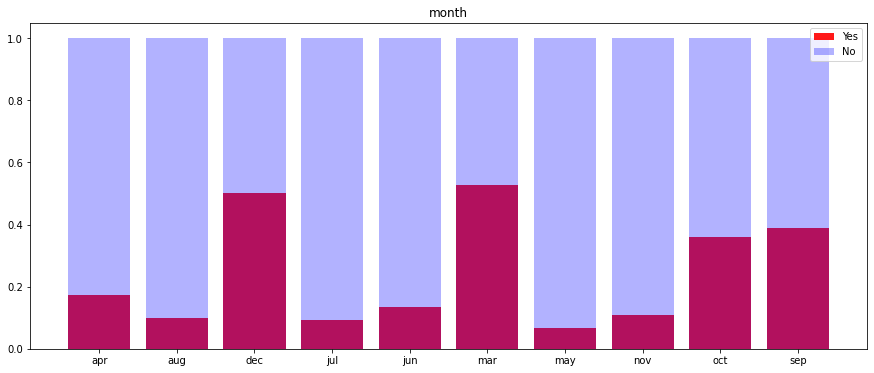

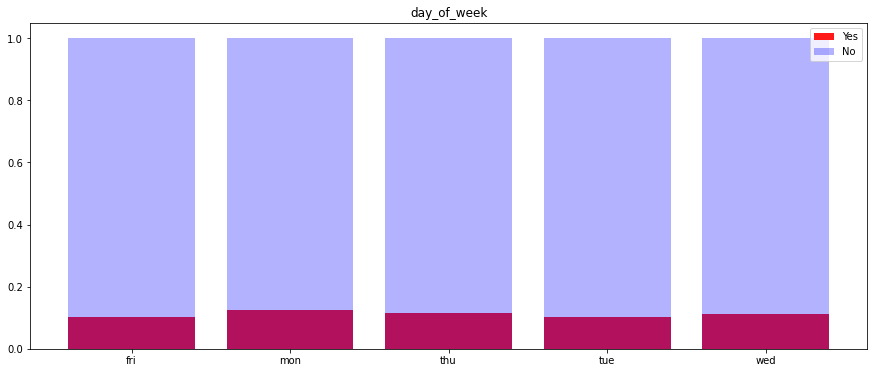

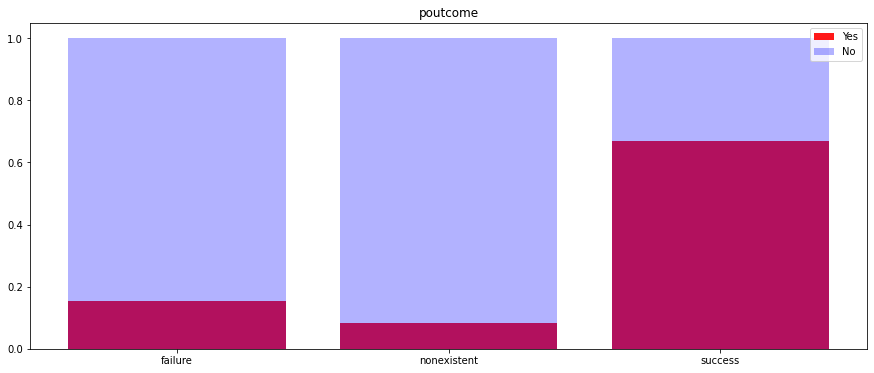

In [4]:
cat_features = ['job', 'marital', 'education', 'default', 
                'housing', 'loan', 'contact', 'month', 
                'day_of_week', 'poutcome']

for cat in cat_features:
    positive_proportion(train_df, cat)

В переменных 'poutcome', 'month', 'contact', 'job', 'education' заметно различаются доли положительных исходов по категориям, что может быть репрезентативно для классификатора. Произведем one-hot-encoding данных переменных. 

In [5]:
def one_hot_transform(train, cat_features):
  """
  Function for one-hot encoding of discrete variable
  """
  final_columns = []

  for feature in cat_features:
    for category in np.unique(np.array(train[feature])):
      train[category] = np.array([0]*len(train))
      final_columns.append(category)

    for i in range(len(train)):
      train[train[feature][i]][i] = 1
    
  return train[final_columns]

In [ ]:
cat_features =['poutcome', 'month', 'contact', 'job']
train_one_hot = one_hot_transform(train_df.copy(), cat_features)

### Анализ непрерывных переменных

In [50]:
def cont_vars(data, vars):
  """
  Function for vizualization of variables distribution for targets 0 and 1 by boxplot
  """
  for var in vars:
    target_0 = data[data['y']=='no'][var]
    target_1 = data[data['y']=='yes'][var]
    plt.figure()
    plt.title('Disctribution for {} with target 0 and 1'.format(var))
    plt.boxplot((target_0, target_1), positions = (1,2), labels=['0', '1'])

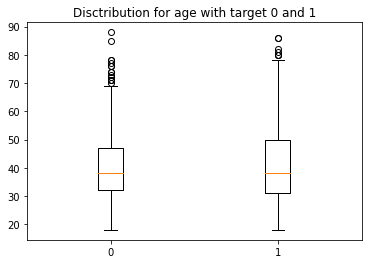

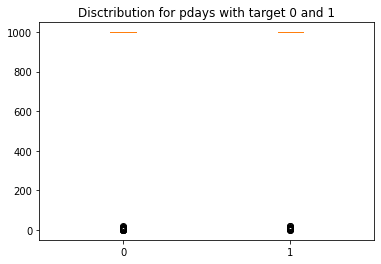

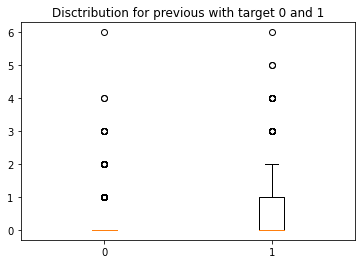

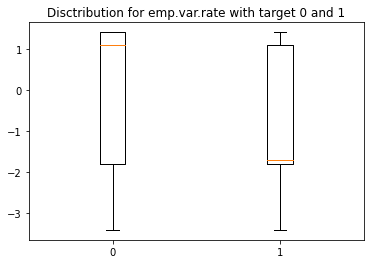

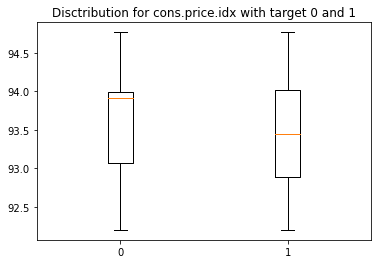

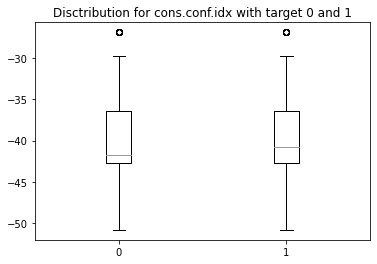

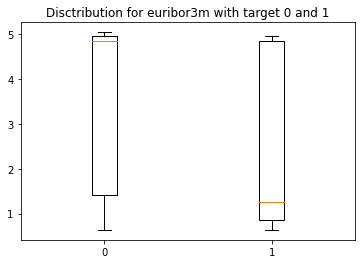

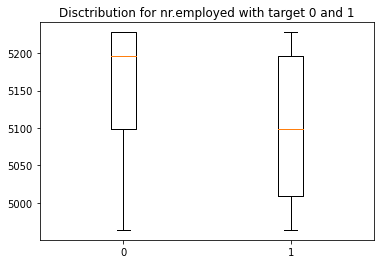

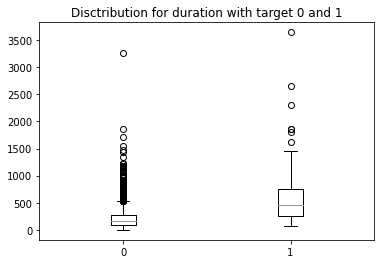

In [52]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
cont_vars(train_df, ['age', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
                     'cons.conf.idx', 'euribor3m', 'nr.employed', 'duration'])

В переменных 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed', 'duration' заметны различия медианы и/или межквартильного размаха. Такие переменные могут быть репрезентативными признаками.  

#### Анализ корреляции репрезентативных переменных

In [9]:
representative = ['previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed', 'duration'] 
corr = train_df[representative].corr()
corr.style.background_gradient(cmap='coolwarm')

,previous,emp.var.rate,cons.price.idx,euribor3m,nr.employed,duration
previous,1.000000,-0.409944,-0.141692,-0.458122,-0.520039,0.025395
emp.var.rate,-0.409944,1.000000,0.747513,0.969968,0.892328,-0.028857
cons.price.idx,-0.141692,0.747513,1.000000,0.645568,0.450870,0.022067
euribor3m,-0.458122,0.969968,0.645568,1.000000,0.940434,-0.033147
nr.employed,-0.520039,0.892328,0.450870,0.940434,1.000000,-0.046760
duration,0.025395,-0.028857,0.022067,-0.033147,-0.046760,1.000000


Заметна сильная корреляция для переменных 'emp.var.rate', 'euribor3m'. Такая корреляция может отрицательно повлиять на качество классификации. Построим корреляционную карту без данных переменных.

In [10]:
representative = ['previous', 'cons.price.idx', 'nr.employed', 'duration'] 
corr = train_df[representative].corr()
corr.style.background_gradient(cmap='coolwarm')

,previous,cons.price.idx,nr.employed,duration
previous,1.000000,-0.141692,-0.520039,0.025395
cons.price.idx,-0.141692,1.000000,0.450870,0.022067
nr.employed,-0.520039,0.450870,1.000000,-0.046760
duration,0.025395,0.022067,-0.046760,1.000000


Теперь сильная корреляция между переменными не наблюдается. 

### Обучение и валидация случайного леса

In [11]:
train_data = pd.concat((train_one_hot, train_df[representative]), axis=1)
train_labels = [1 if y == 'yes' else 0 for y in train_df['y']]

In [12]:
classifier = RandomForestClassifier()

X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size = 0.2)
classifier.fit(X_train , y_train)
y_pred = classifier.predict(X_valid)

roc_auc = metrics.roc_auc_score(y_valid, y_pred)
acc = metrics.accuracy_score(y_valid, y_pred)
f1 = metrics.f1_score(y_valid, y_pred)

print("Accuracy: ", round(acc, 3))
print("F1: ", round(f1, 3))
print("ROC_AUC: ", round(roc_auc, 3))

Accuracy:  0.891
F1:  0.533
ROC_AUC:  0.736


### XGBClassifier

In [21]:
model = xgb.XGBClassifier(max_depth=3, n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

roc_auc = metrics.roc_auc_score(y_valid, y_pred)
acc = metrics.accuracy_score(y_valid, y_pred)
f1 = metrics.f1_score(y_valid, y_pred)

print("Accuracy: ", round(acc, 3))
print("F1: ", round(f1, 3))
print("ROC_AUC: ", round(roc_auc, 3))

Accuracy:  0.901
F1:  0.515
ROC_AUC:  0.706


В данных присутствует значительное преобладание отрицательных семплов, что отражается в высоком значении для accuracy и низком для F1.

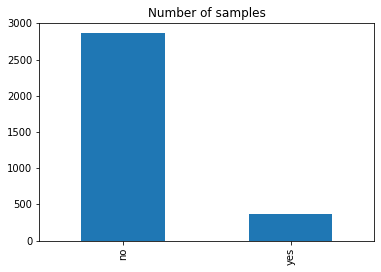

In [14]:
train_df['y'].value_counts().plot(kind='bar', title='Number of samples')

Сделаем oversampling для балансировки классов.

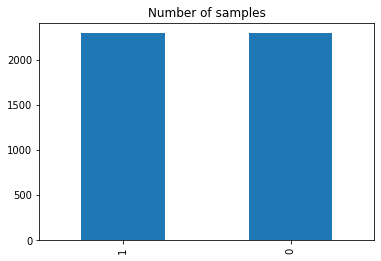

In [57]:
from imblearn.over_sampling import RandomOverSampler
simplefilter(action='ignore', category=FutureWarning)

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

X_train_over = pd.DataFrame(X_ros)
y_train_over = pd.DataFrame(y_ros)
X_train_over.columns = X_valid.columns

y_train_over[0].value_counts().plot(kind='bar', title='Number of samples');

Обучение XGBClassifier oversampling'а

In [35]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=10)
model.fit(X_train_over, y_train_over[0])
y_pred = model.predict(X_valid)

roc_auc = metrics.roc_auc_score(y_valid, y_pred)
acc = metrics.accuracy_score(y_valid, y_pred)
f1 = metrics.f1_score(y_valid, y_pred)

print("Accuracy: ", round(acc, 3))
print("F1: ", round(f1, 3))
print("ROC_AUC: ", round(roc_auc, 3))

Accuracy:  0.856
F1:  0.601
ROC_AUC:  0.889


Метрики F1 и ROC_AUC классификации для XGBClassifier, обученного на отбалансированном датасете заметно выше, чем для XGBClassifier на стандартном датасете и выше метрик, полученных для случайного леса.

### Результаты на валидационное выборке

* Accuracy:  0.856
* F1:  0.601
* ROC_AUC:  0.889

## Предсказание для тестовой выборки

In [ ]:
test_one_hot = one_hot_transform(test_df.copy(), cat_features)
test_data = pd.concat((test_one_hot, test_df[representative]), axis=1)
test_labels = [1 if y == 'yes' else 0 for y in train_df['y']]

y_pred = model.predict(test_data)

In [42]:
result_df = test_df
result_df['y'] = ['yes' if label == 1 else 'no' for label in y_pred]
result_df.to_excel('/content/drive/MyDrive/sasha_test/task2_result.xlsx', index=False)

Результат для тестовой выборки сохранен в столбец 'y' файла task2_result.xlsx